<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#5. Extended and Unscented Kalman Filtering

This notebook replicates the figures of Chapter 5 of Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



## 5.0 Imports

In [111]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

## 5.2 Extended Kalman Filter

First, we simulate the pendulum data using the following transition model:
\begin{align*}
  \begin{pmatrix} x_{1,k} \\ x_{2,k} \end{pmatrix} &= 
  \begin{pmatrix} x_{1,k-1} + x_{2,k-1} \Delta t \\
    x_{2,k-1} - g \sin(x_{1,k-1}) \Delta t
  \end{pmatrix} + q_{k-1} \\
  y_{k} &= \sin(x_{1,k}) + r_k \\
  y_{x_k} &= \arcsin(y_k) = \arcsin(\sin(x_{1,k}) + r_k)
\end{align*}

In [170]:
# Function to simulate pendulum
def simulate_pendulum(key, m_0, f, Q, h, r, steps):
    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)
        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.normal(rng2) * r
        return next_state, (next_state, obs)

    M = m_0.shape[-1]
    state = m_0
    rngs = jr.split(key, steps)
    _, (states, observations) = lax.scan(
        _step, state, rngs
    )
    return states, observations

In [171]:
# Params for pendulum simulation
key = jr.PRNGKey(0)
m_0 = jnp.array([[jnp.pi/2, 0]])
dt = 0.0125
q = 1
g = 9.8
Q = jnp.array([[q*dt**3/3, q*dt**2/2],
               [q*dt**2/2,      q*dt]])
r = 0.3
f = lambda x: jnp.array([[x[0,0] + x[0,1]*dt, x[0,1] - g*jnp.sin(x[0,0])*dt]])
h = lambda x: jnp.array([jnp.sin(x[0,0])])

# Simulate pendulum angle
states, obs = simulate_pendulum(key, m_0, f, Q, h, r, 400)

# # Apply arcsin to measured horizontal position to compute measured angle
# obs_angle = jnp.arcsin(jnp.clip(obs[:,0], -1, 1)) 

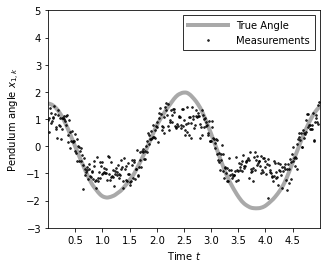

In [172]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
# plt.plot(m_kf[:,0], m_kf[:,1], color='k', linewidth=1.5, label="Filter Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we use a first-order EKF to estimate the angle of pendulum from the noisy measurements.

In [173]:
# First order additive EKF
def ekf_firstorder_additive(m_0, P_0, f, F, Q, h, H, R, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = f(m_k)
        P_pred = F(m_k) @ P_k @ F(m_k).T + Q

        # Update
        v = Y[t] - h(m_pred)
        S = H(m_pred) @ P_pred @ H(m_pred).T + R
        K = P_pred @ H(m_pred).T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ v
        P_post = P_pred - K @ S @ K.T

        return (m_post, P_post), (m_post, P_post)
    
    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [174]:
# Additional params for EKF
F = lambda x: jnp.array([[1, dt], [-g * jnp.cos(x[0][0]) * dt, 1]])
H = lambda x: jnp.array([[jnp.cos(x[0][0]), 0]])
m_0 = jnp.array([[jnp.pi/2, 0]])
P_0 = jnp.eye(2)

m_ekf, P_ekf = ekf_firstorder_additive(m_0, P_0, f, F, Q, h, H, r, obs)

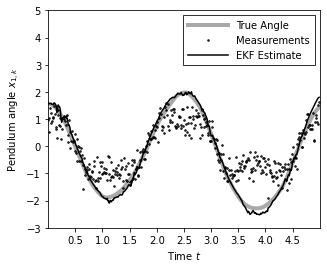

In [175]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.plot(time_grid, m_ekf[:,0,0], color='k', linewidth=1.5, label="EKF Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Finally, we compute the RMSE of the EKF estimate.

In [179]:
# Helper function to compute RMSE
def compute_rmse(y, y_est):
    num_samples = y.shape[0]
    return jnp.sqrt(jnp.sum((y-y_est)**2)/num_samples)

# Compute RMSE of the EKF estimate
rmse = compute_rmse(states[:,0,0], m_ekf[:,0,0])

print(f'The RMSE of the EKF estimate of the angle is: {rmse:.2f},')
print(f'The standard deviation of measurement noise is: {jnp.sqrt(r):.2f}')

The RMSE of the EKF estimate of the angle is: 0.14,
The standard deviation of measurement noise is: 0.55


## 5.3 Statistical Linearization